<a href="https://colab.research.google.com/github/koseki3104/biginner_practice202506/blob/main/%E5%8C%BB%E7%99%82%E8%B2%BB%E4%BA%88%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/SIGNATE/【2025.06】医療保険の費用帯予測')


In [3]:
import pandas as pd
test = pd.read_csv("test.csv")
train = pd.read_csv('train.csv')

In [9]:
#基本情報
print(train.info())
print(train.isnull().sum())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        1600 non-null   int64  
 1   age       1600 non-null   int64  
 2   sex       1600 non-null   object 
 3   bmi       1600 non-null   float64
 4   children  1600 non-null   int64  
 5   smoker    1600 non-null   object 
 6   region    1600 non-null   object 
 7   charges   1600 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 100.1+ KB
None
id          0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
               id          age          bmi     children      charges
count  1600.00000  1600.000000  1600.000000  1600.000000  1600.000000
mean   1007.86250    38.985000    32.424376     1.014375     0.306250
std     575.26841    13.555012     5.766915     1.259031     0.628656
min       0.00000    18.000000

In [8]:
#相関行列
train_df = train.select_dtypes(include=['int64', 'float64'])
correlation_matrix = train_df.corr()
print(correlation_matrix)

                id       age       bmi  children   charges
id        1.000000  0.005803  0.039221  0.012440  0.013463
age       0.005803  1.000000  0.019885  0.011519  0.102112
bmi       0.039221  0.019885  1.000000  0.083677  0.171282
children  0.012440  0.011519  0.083677  1.000000  0.026830
charges   0.013463  0.102112  0.171282  0.026830  1.000000


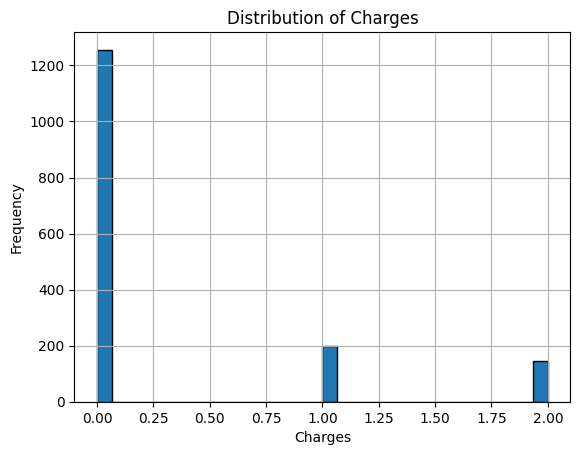

In [9]:
import matplotlib.pyplot as plt

# ヒストグラムの描画
plt.hist(train['charges'], bins=30, edgecolor='black')
plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [4]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.8 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import optuna

# ラベルエンコーダー
le_sex = LabelEncoder()
le_smoker = LabelEncoder()
le_region = LabelEncoder()

# データ前処理（エンコーディング）
train['sex'] = le_sex.fit_transform(train['sex'])
train['smoker'] = le_smoker.fit_transform(train['smoker'])
train['region'] = le_region.fit_transform(train['region'])

test['sex'] = le_sex.transform(test['sex'])
test['smoker'] = le_smoker.transform(test['smoker'])
test['region'] = le_region.transform(test['region'])

# 説明変数と目的変数
X = train.drop(columns=['charges', 'id'])
y = train['charges']
X_test = test.drop(columns=['id'])

# 学習・検証データに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Optunaの目的関数（MSEを最小化）
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

# Optunaによるチューニング実行（例：100試行）
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=80)

# 最適パラメータの取得と学習
best_params = study.best_params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X, y)

# テストデータで予測
y_pred_all = best_model.predict(X_test)

# 提出ファイル作成
sample = pd.read_csv("sample_submit.csv")
sample['charges'] = y_pred_all
sample.to_csv('sample_submit_optuna.csv', index=False, header=False)

# 最適パラメータ表示
print("Best parameters found by Optuna:")
print(best_params)

[I 2025-06-27 10:19:46,056] A new study created in memory with name: no-name-7c0113a8-1866-46a4-9f96-b10c4fc7ad3b
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:19:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-06-27 10:19:46,885] Trial 0 finished with value: 0.89375 and parameters: {'n_estimators': 66, 'max_depth': 12, 'learning_rate': 0.11391495899906405, 'subsample': 0.6297729170571926, 'colsample_bytree': 0.8298365809333182, 'gamma': 3.6697511434796155, 'reg_alpha': 0.9245268283694896, 'reg_lambda': 3.4939665832538216}. Best is trial 0 with value: 0.89375.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:19:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-06-27 10:19:47,185] Trial 1 finished with value: 0.89375 and parameters: {'n_estimators': 

Best parameters found by Optuna:
{'n_estimators': 126, 'max_depth': 9, 'learning_rate': 0.08557004194809185, 'subsample': 0.6225891097234627, 'colsample_bytree': 0.8992107673213948, 'gamma': 4.309524360712768, 'reg_alpha': 4.733018221713004, 'reg_lambda': 4.709659624979591, 'random_state': 42, 'n_jobs': -1, 'use_label_encoder': False, 'eval_metric': 'mlogloss'}


In [5]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# ----------------------------------
# 設定
# ----------------------------------
RANDOM_STATE = 42
TARGET_COLUMN = 'charges'
ID_COLUMN = 'id'
CATEGORICAL_COLUMNS = ['sex', 'smoker', 'region']

# ----------------------------------
# ラベルエンコーディング関数
# ----------------------------------
def label_encode_columns(train_df, test_df, columns):
    encoders = {}
    for col in columns:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        encoders[col] = le
    return train_df, test_df, encoders

# ----------------------------------
# Optuna目的関数
# ----------------------------------
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)

# ラベルエンコーディング
train, test, encoders = label_encode_columns(train, test, CATEGORICAL_COLUMNS)

# 説明変数・目的変数の設定
X = train.drop(columns=[TARGET_COLUMN, ID_COLUMN])
y = train[TARGET_COLUMN]
X_test = test.drop(columns=[ID_COLUMN])

# 学習データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Optunaによるハイパーパラメータ探索
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適パラメータでモデル再学習
best_params = study.best_params
best_params.update({
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
})
final_model = XGBClassifier(**best_params)
final_model.fit(X, y)

# 予測と出力
y_pred_all = final_model.predict(X_test)
submit = pd.read_csv("sample_submit.csv")
submit[TARGET_COLUMN] = y_pred_all
submit.to_csv("sample_submit_optuna_xgb.csv", index=False, header=False)

# 結果表示
print("Best parameters found by Optuna:")
print(best_params)


[I 2025-06-27 10:12:44,821] A new study created in memory with name: no-name-e01ce538-b122-4d61-8ee6-706f00cc128e
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:12:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-06-27 10:12:46,913] Trial 0 finished with value: 0.8875 and parameters: {'n_estimators': 193, 'max_depth': 11, 'learning_rate': 0.24099446477057662, 'subsample': 0.6746631769256666, 'colsample_bytree': 0.9885521328929401, 'gamma': 0.6003892712777548, 'reg_alpha': 2.555511452114368, 'reg_lambda': 4.661649706193805}. Best is trial 0 with value: 0.8875.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:12:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-06-27 10:12:49,625] Trial 1 finished with value: 0.8875 and parameters: {'n_estimators': 183,

Best parameters found by Optuna:
{'n_estimators': 229, 'max_depth': 7, 'learning_rate': 0.08241451871440068, 'subsample': 0.7854605359626237, 'colsample_bytree': 0.6015061880784127, 'gamma': 0.7157379029547772, 'reg_alpha': 2.0381067000709514, 'reg_lambda': 4.649112468674556, 'random_state': 42, 'n_jobs': -1, 'use_label_encoder': False, 'eval_metric': 'mlogloss'}
